## **Mounting Drive**

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

# Importing modules
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import json

from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf

from sklearn.model_selection import train_test_split
from random import randint

# Define save path
save_path = "insert_own_drive_folder_save_path_here/"

Mounted at /content/gdrive


## **Creating Training Data for Fruit Image Detection**

In [ ]:
train_zip_file_path = save_path + 'fruits_train.zip'
train_extracted_folder_path = save_path + 'fruits_train'

# Unzip the file
with zipfile.ZipFile(train_zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(train_extracted_folder_path)

In [ ]:
train_images = []
train_labels = []
train_labels_ids = []
shape = (200, 200)

for root, dirs, files in os.walk(train_extracted_folder_path):
    for filename in files:
        if filename.split('.')[1] == 'jpg':

            # Spliting file names and storing the labels for image in list
            train_labels_ids.append(filename.split('_')[0])
            train_labels.append(filename.split('_')[0])

            # Resize all images to a specific shape (200, 200)
            img = cv2.imread(os.path.join(train_extracted_folder_path + '/train' , filename))
            train_images.append(cv2.resize(img,shape))

train_labels_ids = pd.get_dummies(train_labels_ids).values # 1 hot encoding of train_labels
train_images = np.array(train_images) # Converting test_images to array

In [ ]:
# Splitting training data into train and val
# Since n_samples is not specified, the entire dataset will be used
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels_ids, test_size=0.25, random_state=1)

## **Creating Test Data for Fruit Image Detection**

In [ ]:
# Processing testing data
test_zip_file_path = save_path + 'fruits_test.zip'
test_extracted_folder_path = save_path + 'fruits_test'

# Unzip the file
with zipfile.ZipFile(test_zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(test_extracted_folder_path)

In [ ]:
# -> appending images in a list 'test_images'
# -> appending labels in a list 'test_labels'

test_images = []
test_labels = []
test_labels_ids = []
shape = (200,200)

for root, dirs, files in os.walk(test_extracted_folder_path):
    for filename in files:
        if filename.split('.')[1] == 'jpg':

            # Spliting file names and storing the labels for image in list
            test_labels_ids.append(filename.split('_')[0])
            test_labels.append(filename.split('_')[0])

            # Resize all images to a specific shape (200, 200)
            img = cv2.imread(os.path.join(test_extracted_folder_path + '/test' , filename))
            test_images.append(cv2.resize(img,shape))

test_labels_ids = pd.get_dummies(test_labels_ids).values # 1 hot encoding of test_labels
test_images = np.array(test_images) # Converting test_images to array

x_test, y_test  = test_images, test_labels_ids   #get test data

## **Visualizing Training Data**

apple
[1 0 0 0]


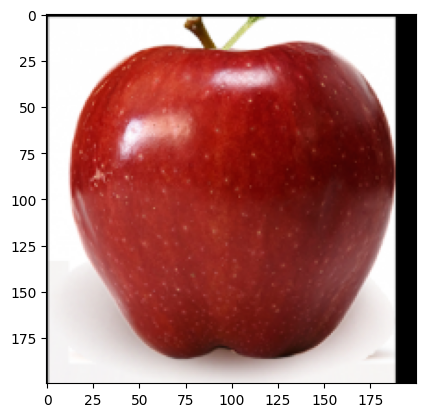

In [ ]:
# Visualizing Training data
print(train_labels[0])  # label of image
print(train_labels_ids[0]) # 1 hot encoded label of image
img_rgb = cv2.cvtColor(train_images[0], cv2.COLOR_BGR2RGB) # change from bgr to rgb for visualization
plt.imshow(img_rgb)  # image

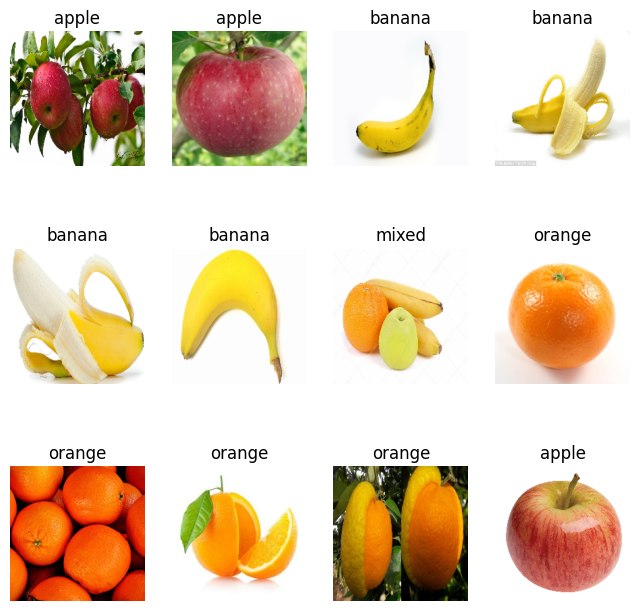

In [ ]:
# Visualizing Training data
columns = 4
rows = 3

fig = plt.figure(figsize=(8, 8))

for i in range(1, columns*rows +1):
	# define subplot
  fig.add_subplot(rows, columns, i)
  img_rgb = cv2.cvtColor(train_images[17*i], cv2.COLOR_BGR2RGB) # change from bgr to rgb for visualization

  plt.imshow(img_rgb)
  plt.title(train_labels[17*i])
  plt.axis("off")

# show the figure
plt.show()

In [ ]:
#train_images is a tensor of the shape (240, 200, 200, 3). This is a batch of 240 images of shape 200x200x3 (the last dimension refers to color channels RGB).
print(train_images.shape)

#train_labels_ids is a tensor of the shape (240, 4), these are corresponding 1 hot encoded labels to the 240 images.
print(train_labels_ids.shape)

(240, 200, 200, 3)
(240, 4)


## **Rescaling the Data**

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general we should seek to make our input values small.

Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [ ]:
print("Shape:", np.min(test_images[0]), np.max(test_images[0]))

Shape: 0 255


In [ ]:
rescaling_layer = layers.Rescaling(1./255, input_shape=(200,200,3,))  #add a layer to rescale image values from (0,255) to (0,1)

## **Creating Sequential Model**

In [ ]:
# Creating a Sequential model

model = Sequential()

model.add(rescaling_layer)  #add rescaling layer

model.add(Conv2D(kernel_size=(3,3), filters=32, activation='relu', input_shape=(200,200,3,)))

model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(Flatten())

model.add(Dense(20,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dense(4,activation = 'softmax'))


model.compile(
              loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer='adam'
             )

# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 196, 30)      8670      
                                                                 
 max_pooling2d (MaxPooling2  (None, 98, 98, 30)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 30)        8130      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 30)        0         
 g2D)                                                   

## **Training the Model**

In [ ]:
# Training the model
epochs = 15

history = model.fit(x_train,y_train,epochs=epochs,batch_size=50,validation_data=(x_val,y_val))

Epoch 1/15
4/4 [==============================] - 27s 6s/step - loss: 1.3341 - acc: 0.3667 - val_loss: 1.3721 - val_acc: 0.3833
Epoch 2/15
4/4 [==============================] - 28s 7s/step - loss: 1.1725 - acc: 0.5056 - val_loss: 0.9384 - val_acc: 0.6833
Epoch 3/15
4/4 [==============================] - 27s 7s/step - loss: 0.7765 - acc: 0.7833 - val_loss: 0.7369 - val_acc: 0.7333
Epoch 4/15
4/4 [==============================] - 26s 6s/step - loss: 0.5651 - acc: 0.8222 - val_loss: 0.4740 - val_acc: 0.8667
Epoch 5/15
4/4 [==============================] - 26s 7s/step - loss: 0.3948 - acc: 0.8889 - val_loss: 0.4737 - val_acc: 0.8333
Epoch 6/15
4/4 [==============================] - 25s 6s/step - loss: 0.2820 - acc: 0.9056 - val_loss: 0.3125 - val_acc: 0.8667
Epoch 7/15
4/4 [==============================] - 36s 10s/step - loss: 0.1735 - acc: 0.9556 - val_loss: 0.7831 - val_acc: 0.7333
Epoch 8/15
4/4 [==============================] - 28s 7s/step - loss: 0.1537 - acc: 0.9333 - val_loss: 

In [ ]:
# saving model to drive
model.save(save_path + "Sequential_model.keras")

In [ ]:
#save history to drive
filename = "sequential_model_history.json"

os.makedirs(save_path, exist_ok=True)

with open(os.path.join(save_path, filename), 'w') as f:
    json.dump(history.history, f)

In [ ]:
# loading saved model from drive
model = tf.keras.models.load_model(save_path + "Sequential_model.keras")

In [ ]:
# load history from drive
filename = "sequential_model_history.json"

with open(os.path.join(save_path, filename), 'r') as f:
    history = json.load(f)

## **Visualise Training Results**


Create plots of the loss and accuracy on the training and validation sets:

The plots show that training loss and validation loss are off by a significant margin towards the end of the training.

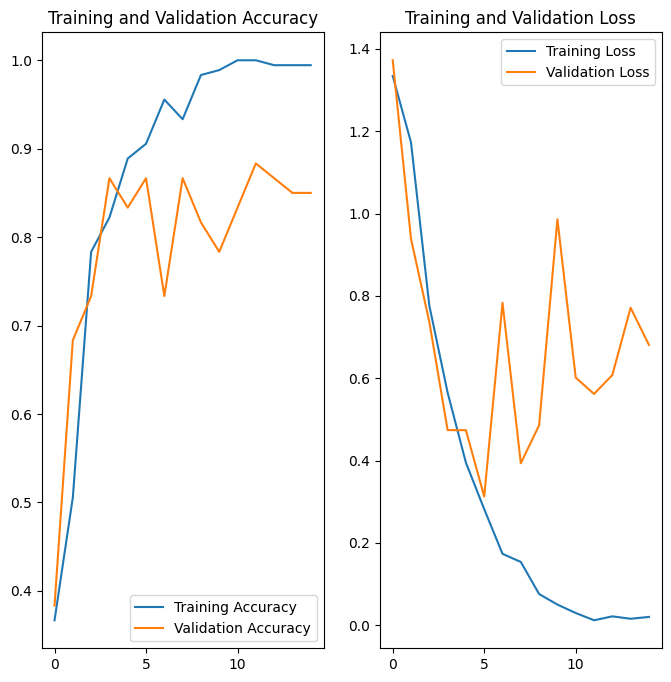

In [ ]:
# loading up history from drive

acc = history['acc']
val_acc = history['val_acc']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Evaluation and Prediction**

In [ ]:
# Evaluating model on test data
evaluate = model.evaluate(x_test,y_test)

2/2 [==============================] - 2s 883ms/step - loss: 1.2066 - acc: 0.8333


Actual: apple
Predicted: apple
This image most likely belongs to a apple with a 75.2505% confidence.


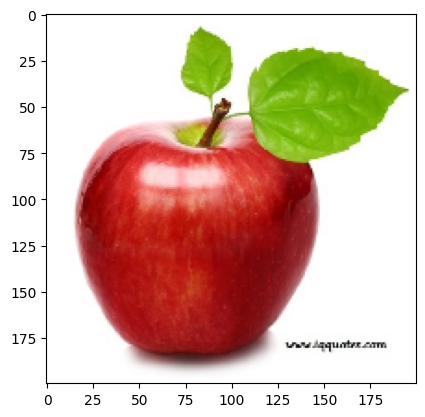

In [ ]:
# Testing predictions and the actual label
random = randint(0, len(test_labels)-1)

checkImage = test_images[random-1:random]
checklabel = test_labels[random]

predict = model.predict(np.array(checkImage), verbose = 0)

output = { 0:'apple',1:'banana',2:'mixed',3:'orange'}

print("Actual:",checklabel)

img_rgb = cv2.cvtColor(test_images[random], cv2.COLOR_BGR2RGB) # change from bgr to rgb for visualization
plt.imshow(img_rgb)
print("Predicted:",output[np.argmax(predict)])

print("This image most likely belongs to a", output[np.argmax(predict)], "with a" , "{:.4f}".format(100*np.max(predict[0]), 3) + "% confidence.")

## **Overfitting Techniques - Data Augmentation, Dropout and Callbacks**

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. We will use data augmentation, add dropout and callbacks to the Sequential model.

## **Data Augmentation**

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from our existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using the following Keras preprocessing layers:

1. tf.keras.layers.RandomFlip
2. tf.keras.layers.RandomRotation
3. tf.keras.layers.RandomZoom

These will be included inside our model like other layers, and run on the GPU.

In [ ]:
import keras

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(200,
                                  200,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

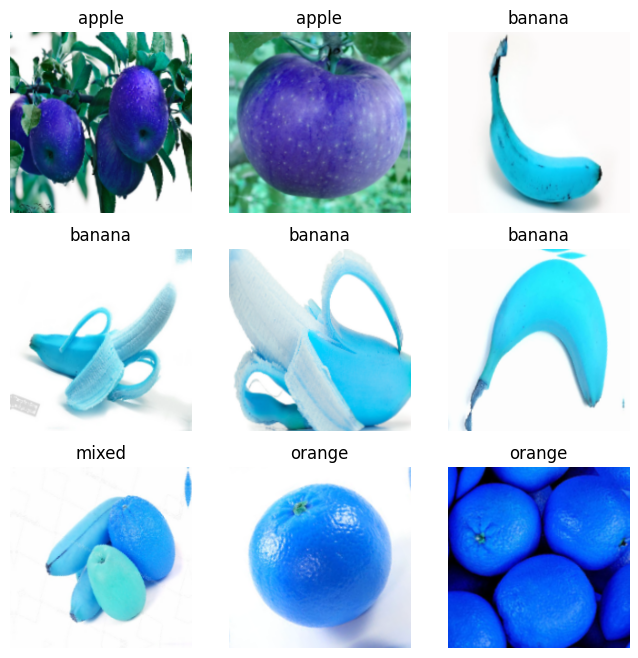

In [ ]:
#Visualize a few augmented examples by applying data augmentation to the same image several times:
columns = 3
rows = 3

fig = plt.figure(figsize=(8, 8))

for i in range(1, columns*rows +1):
  augmented_images = data_augmentation(train_images)

	# define subplot
  fig.add_subplot(rows, columns, i)

  plt.imshow(augmented_images[17*i].numpy().astype("uint8"))

  plt.title(train_labels[17*i])
  plt.axis("off")

# show the figure
plt.show()

## **Dropout**

Another technique to reduce overfitting is to introduce dropout regularization to the network.

When we apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [ ]:
#Creating Sequential Model with Data Augmentation and Dropout Layers
model = Sequential()

model.add(data_augmentation)  #add data augmentation

model.add(rescaling_layer)  #add a layer to rescale image values from (0,255) to (0,1)

model.add(Conv2D(kernel_size=(3,3), filters=32, activation='relu', input_shape=(200,200,3,)))

model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.25))  #add dropout layer

model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.25))  #add dropout layer

model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))

model.add(Flatten())

model.add(Dense(20,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dense(4,activation = 'softmax'))


model.compile(
              loss='categorical_crossentropy',
              metrics=['acc'],
              optimizer='adam'
             )

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 196, 196, 30)      8670      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 98, 98, 30)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 98, 98, 30)        0         
                                                      

## **Callbacks**

A callback is a function that is called repeatedly during a process (for example the training of a neural network) and which generally serves to validate or correct certain behaviors.

In machine learning, we can use callbacks to define what happens before, during, or at the end of a training epoch. This is especially useful to log performance or to stop training if our performance metric reaches a certain threshold. This mechanism is called early stopping, saving us from potentially overfitting your model.

In [ ]:
## Define your callbacks
Model_Checkpoint = tf.keras.callbacks.ModelCheckpoint(
    save_path + "Sequential_model_improved.keras", #save best model to drive
    monitor='val_loss',
    save_best_only='True',
    verbose=1
)

Early_Stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,  # number of epochs the model has to continue training before terminating after it has seen no improvements in the score for the monitor parameter.
    verbose=1,
    restore_best_weights='True',
    min_delta=0.1   # means the minimum improvement in the monitor score between 2 epochs and below this threshold, the change in monitor score is not considered an improvement.
)

In [ ]:
# Training the model
epochs = 15

improved_history = model.fit(x_train,y_train, callbacks=[Early_Stopping, Model_Checkpoint], epochs=epochs, batch_size=50, validation_data=(x_val,y_val))

Epoch 1/15
4/4 [==============================] - ETA: 0s - loss: 1.4065 - acc: 0.2833
Epoch 1: val_loss improved from inf to 1.35330, saving model to /content/gdrive/MyDrive/Chatbot/CA2/Sequential_model_improved.keras
4/4 [==============================] - 29s 7s/step - loss: 1.4065 - acc: 0.2833 - val_loss: 1.3533 - val_acc: 0.2000
Epoch 2/15
4/4 [==============================] - ETA: 0s - loss: 1.2981 - acc: 0.3333
Epoch 2: val_loss improved from 1.35330 to 1.33195, saving model to /content/gdrive/MyDrive/Chatbot/CA2/Sequential_model_improved.keras
4/4 [==============================] - 29s 7s/step - loss: 1.2981 - acc: 0.3333 - val_loss: 1.3320 - val_acc: 0.2000
Epoch 3/15
4/4 [==============================] - ETA: 0s - loss: 1.2758 - acc: 0.3389
Epoch 3: val_loss improved from 1.33195 to 1.30850, saving model to /content/gdrive/MyDrive/Chatbot/CA2/Sequential_model_improved.keras
4/4 [==============================] - 28s 7s/step - loss: 1.2758 - acc: 0.3389 - val_loss: 1.3085 - 

In [ ]:
#save improved_history to drive
filename = "sequential_model_improved_history.json"

os.makedirs(save_path, exist_ok=True)

with open(os.path.join(save_path, filename), 'w') as f:
    json.dump(improved_history.history, f)

In [ ]:
# loading saved model from drive
model = tf.keras.models.load_model(save_path + "Sequential_Model_After_Data_Augmented.keras")

In [ ]:
# load improved_history from drive
filename = "sequential_model_improved_history.json"

with open(os.path.join(save_path, filename), 'r') as f:
    improved_history = json.load(f)

## **Visualizing Training Results**

After applying data augmentation, tf.keras.layers.Dropout and Callbacks, there is less overfitting than before, and training and validation accuracy are closer aligned:

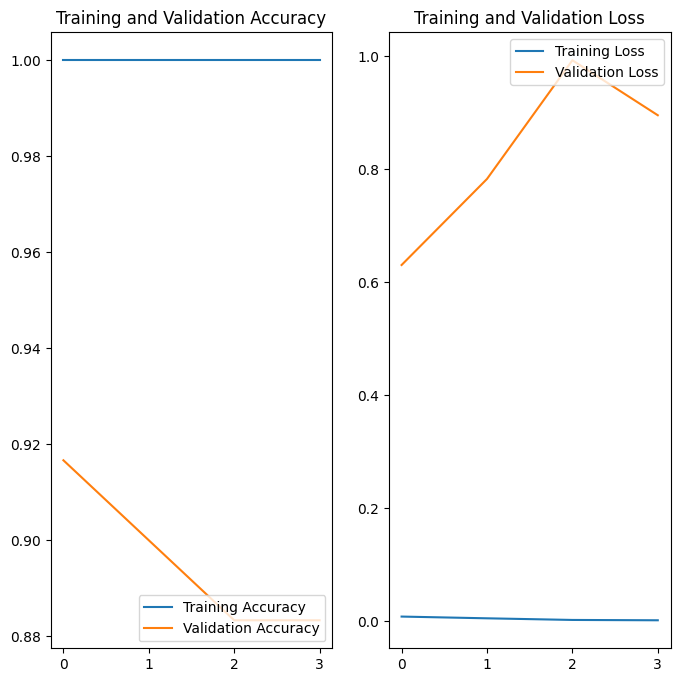

In [ ]:
# loading up improved_history from drive

acc = improved_history['acc']
val_acc = improved_history['val_acc']

loss = improved_history['loss']
val_loss = improved_history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Evaluation and Prediction with Data Augmentation, Dropout and Callbacks**

In [ ]:
# Evaluating model on test data
evaluate = model.evaluate(x_test,y_test)

2/2 [==============================] - 2s 836ms/step - loss: 0.8567 - acc: 0.8333


(60, 200, 200, 3)
(1, 200, 200, 3)
Actual: apple
Predicted: apple
This image most likely belongs to a apple with a 53.7198% confidence.


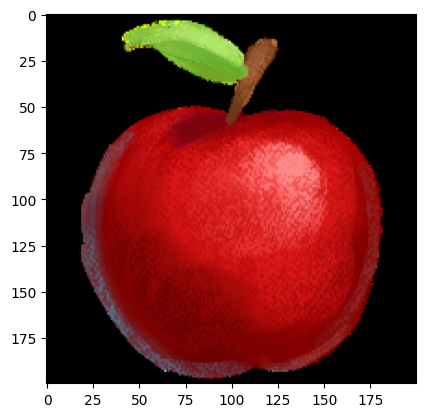

In [ ]:
# Testing predictions and the actual label
random = randint(0, len(test_labels)-1)

checkImage = test_images[random-1:random]
checklabel = test_labels[random]

print(test_images.shape)
print(checkImage.shape)
predict = model.predict(np.array(checkImage), verbose = 0)

output = { 0:'apple',1:'banana',2:'mixed',3:'orange'}

print("Actual:",checklabel)

img_rgb = cv2.cvtColor(test_images[random], cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
print("Predicted:",output[np.argmax(predict)])

print("This image most likely belongs to a", output[np.argmax(predict)], "with a" , "{:.4f}".format(100*np.max(predict[0]), 3) + "% confidence.")

## **Predicting New Data**

Use your model to classify an image that wasn't included in the training, validation or test sets.

74666/74666 [==============================] - 0s 0us/step
This image most likely belongs to a banana with a 98.5786% confidence.


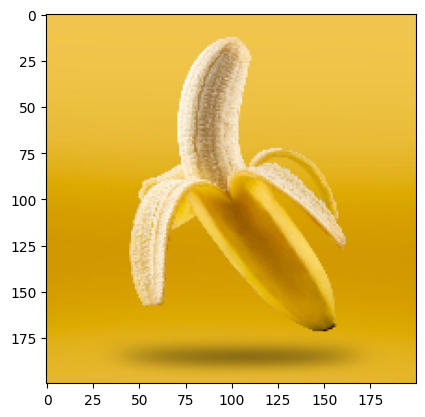

In [ ]:
banana_url = "https://parade.com/.image/ar_1:1%2Cc_fill%2Ccs_srgb%2Cfl_progressive%2Cq_auto:good%2Cw_1200/MTk3MDYyOTU3MDI3MzA0NzY3/are-bananas-good-for-you.jpg"
banana_path = tf.keras.utils.get_file(origin=banana_url)

img = tf.keras.utils.load_img(
    banana_path, target_size=(200, 200)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predict = model.predict(np.array(img_array), verbose = 0)

output = { 0:'apple',1:'banana',2:'mixed',3:'orange'}
plt.imshow(img)

print("This image most likely belongs to a", output[np.argmax(predict)], "with a" , "{:.4f}".format(100*np.max(predict[0]), 3) + "% confidence.")

Use our model to classify an image from another dataset.

In [ ]:
freshapples = []
freshbanana = []
freshoranges = []

freshapples_labels = ['apple']
freshbanana_labels = ['banana']
freshoranges_labels = ['orange']

freshapples_path = save_path + 'freshapples'
freshbanana_path = save_path + 'freshbanana'
freshoranges_path = save_path + 'freshoranges'

shape = (200, 200)

# Fresh Apples
for root, dirs, files in os.walk(freshapples_path):
    # print(files)
    for filename in files:
        img = cv2.imread(os.path.join(freshapples_path , filename))
        freshapples.append(cv2.resize(img,shape))

freshapples = np.array(freshapples) # Converting test_imagmes to array

# Fresh Bananas
for root, dirs, files in os.walk(freshbanana_path):
    # print(files)
    for filename in files:
        img = cv2.imread(os.path.join(freshbanana_path , filename))
        freshbanana.append(cv2.resize(img,shape))

freshbanana = np.array(freshbanana) # Converting test_images to array

# Fresh Oranges
for root, dirs, files in os.walk(freshoranges_path):
    # print(files)
    for filename in files:
        img = cv2.imread(os.path.join(freshoranges_path , filename))
        freshoranges.append(cv2.resize(img,shape))

freshoranges = np.array(freshoranges) # Converting test_images to array


Actual: banana
Predicted: banana
This image most likely belongs to a banana with a 99.8508% confidence.


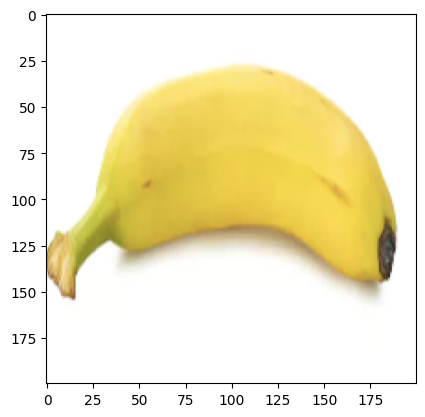

In [ ]:
# Testing predictions and the actual label
fruit_function_list = [freshapples, freshbanana, freshoranges]
fruit_label_list = [freshapples_labels, freshbanana_labels, freshoranges_labels]

random_number = randint(0,2) #choose random number to get freshapples, freshbanana or freshoranges

fruit_function = fruit_function_list[random_number]
fruit_label = fruit_label_list[random_number]

random = randint(0, len(fruit_function)-1)

checkImage = fruit_function[random-1:random] #from chosen fruit, choose random number to get specific image of chosen fruit
checklabel = fruit_label[0]

predict = model.predict(np.array(checkImage), verbose = 0)

output = { 0:'apple',1:'banana',2:'mixed', 3:'orange'}

img_rgb = cv2.cvtColor(fruit_function[random], cv2.COLOR_BGR2RGB)
print("Actual:",checklabel)
plt.imshow(img_rgb)
print("Predicted:",output[np.argmax(predict)])

print("This image most likely belongs to a", output[np.argmax(predict)], "with a" , "{:.4f}".format(100*np.max(predict[0]), 3) + "% confidence.")

## **Transfer Learning of Pre-Trained Model - MobileNet V2**

We will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, we have to pick the layer of MobileNet V2 to use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, the common practice to follow is to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SIZE = (200, 200)
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

NameError: name 'tf' is not defined

In [ ]:
#This feature extractor converts each 200x200x3 image into a 7x7x1280 block of features. Let's see what it does to an example batch of images:

feature_batch = base_model(train_images)
print(feature_batch.shape)

(240, 7, 7, 1280)


## **Feature Extraction**

In this step, we will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, we add a classifier on top of it and train the top-level classifier.

## **Freezing the Convolutional Base**
It is important to freeze the convolutional base before we compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 100, 100, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 100, 100, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 100, 100, 32)         0         ['bn_Conv1[

## **Building Pre-Trained Model**

Build a model by chaining together:

1. data augmentation
2. rescaling
3. freezing base_model
4. apply feature extractor layer
5. apply dropout layer

As previously mentioned, use training = False as our model contains a BatchNormalization layer.

In [ ]:
 #rescale image values from (0,255) to (0,1)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input   #rescaling layer

#To generate predictions from the block of features, average over the spatial 7x7 spatial locations,
#using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   #feature extractor layer
feature_batch_average = global_average_layer(feature_batch)
print("feature_batch_average.shape:", feature_batch_average.shape)


# Apply a tf.keras.layers.Dense layer to convert these features into output of 4 category types
prediction_layer = tf.keras.layers.Dense(4,activation = 'softmax')   #output layer
prediction_batch = prediction_layer(feature_batch_average)
print("prediction_batch.shape:", prediction_batch.shape)

feature_batch_average.shape: (240, 1280)
prediction_batch.shape: (240, 4)


In [ ]:
inputs = tf.keras.Input(shape=(200, 200, 3))

x = data_augmentation(inputs)   # data augmentation

x = preprocess_input(x)       # rescaling layer

x = base_model(x, training=False)   # freezing base_model

x = global_average_layer(x)     # feature extractor layer

x = tf.keras.layers.Dropout(0.2)(x)   # dropout

outputs = prediction_layer(x)   # output layer

pretrained_model = tf.keras.Model(inputs, outputs)

pretrained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 200, 200, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 200, 200, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand trainable parameters in the Dense layer. These are divided between 2 tf.Variable objects, the weights and biases.

In [ ]:
len(pretrained_model.trainable_variables)

2

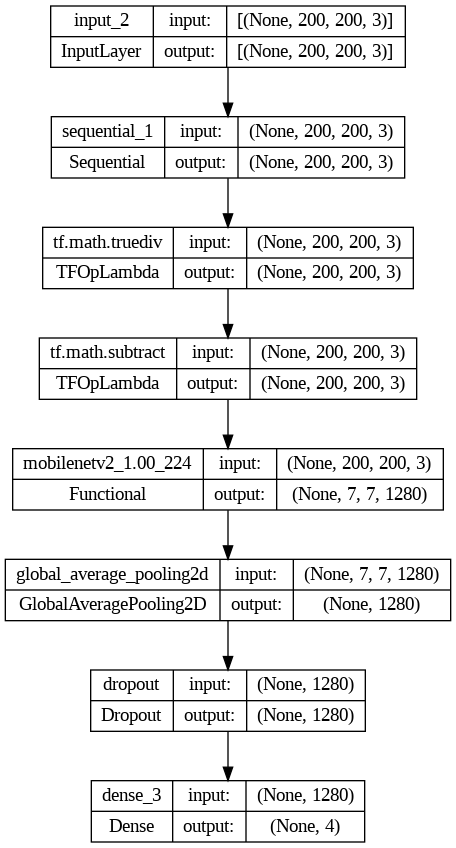

In [ ]:
tf.keras.utils.plot_model(pretrained_model, show_shapes=True)

## **Compiling the Model**

In [ ]:
base_learning_rate = 0.0001
pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    name='categorical_crossentropy'),
              metrics=['acc'])

## **Training the Model**

In [ ]:
initial_epochs = 10

loss0, accuracy0 = pretrained_model.evaluate(x_val, y_val)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2/2 [==============================] - 3s 813ms/step - loss: 1.5819 - acc: 0.2333
initial loss: 1.58
initial accuracy: 0.23


In [ ]:
pretrained_history = pretrained_model.fit(x_train,y_train,epochs=initial_epochs, validation_data=(x_val,y_val))

Epoch 1/10
6/6 [==============================] - 14s 2s/step - loss: 1.3956 - acc: 0.3833 - val_loss: 1.4628 - val_acc: 0.2667
Epoch 2/10
6/6 [==============================] - 11s 2s/step - loss: 1.4219 - acc: 0.3556 - val_loss: 1.3578 - val_acc: 0.3167
Epoch 3/10
6/6 [==============================] - 9s 2s/step - loss: 1.3133 - acc: 0.4722 - val_loss: 1.2758 - val_acc: 0.4000
Epoch 4/10
6/6 [==============================] - 9s 1s/step - loss: 1.3138 - acc: 0.4278 - val_loss: 1.2061 - val_acc: 0.4333
Epoch 5/10
6/6 [==============================] - 10s 2s/step - loss: 1.1944 - acc: 0.4667 - val_loss: 1.1501 - val_acc: 0.4833
Epoch 6/10
6/6 [==============================] - 8s 1s/step - loss: 1.1775 - acc: 0.5111 - val_loss: 1.0954 - val_acc: 0.5167
Epoch 7/10
6/6 [==============================] - 10s 2s/step - loss: 1.1042 - acc: 0.5722 - val_loss: 1.0475 - val_acc: 0.5333
Epoch 8/10
6/6 [==============================] - 9s 2s/step - loss: 1.1305 - acc: 0.5333 - val_loss: 1.004

In [ ]:
#save improved_history to drive
filename = "pretrained_model_history.json"

os.makedirs(save_path, exist_ok=True)

with open(os.path.join(save_path, filename), 'w') as f:
    json.dump(pretrained_history.history, f)

In [ ]:
# load improved_history from drive
filename = "pretrained_model_history.json"

with open(os.path.join(save_path, filename), 'r') as f:
    pretrained_history = json.load(f)

## **Visualizing Training Results**

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

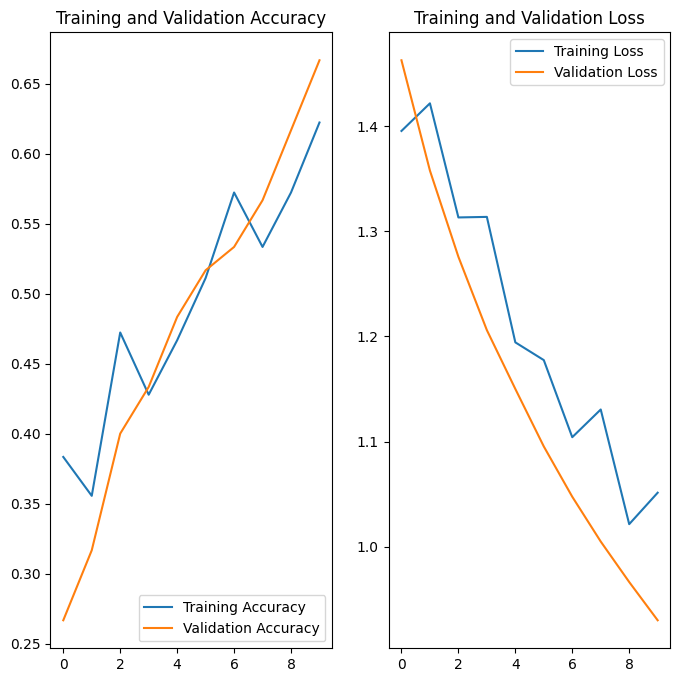

In [ ]:
# loading up pretrained_history from drive

acc = pretrained_history['acc']
val_acc = pretrained_history['val_acc']

loss = pretrained_history['loss']
val_loss = pretrained_history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Fine Tuning**

In the feature extraction training above, we were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.


Also, we will try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As we go higher up, the features are increasingly more specific to the dataset on which the model was trained.


The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

## **Unfreezing the Top Layers of the Model**
We will now unfreeze the base_model and set the bottom layers to be untrainable. Then, we will recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


## **Compiling the Model**

As we are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, our model could overfit very quickly.

In [ ]:
base_learning_rate = 0.0001
pretrained_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    name='categorical_crossentropy'),
              metrics=['acc'])

pretrained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 200, 200, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 200, 200, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
len(pretrained_model.trainable_variables)

56

In [ ]:
print(pretrained_history)

{'loss': [1.3955833911895752, 1.421866774559021, 1.3132877349853516, 1.3138067722320557, 1.1944247484207153, 1.177534818649292, 1.1041827201843262, 1.130537509918213, 1.0214327573776245, 1.0513502359390259], 'acc': [0.38333332538604736, 0.35555556416511536, 0.4722222089767456, 0.4277777671813965, 0.46666666865348816, 0.5111111402511597, 0.5722222328186035, 0.5333333611488342, 0.5722222328186035, 0.6222222447395325], 'val_loss': [1.4628313779830933, 1.3578450679779053, 1.2758389711380005, 1.2060614824295044, 1.1500953435897827, 1.0953766107559204, 1.047516107559204, 1.004900336265564, 0.9663878679275513, 0.9299724102020264], 'val_acc': [0.2666666805744171, 0.3166666626930237, 0.4000000059604645, 0.4333333373069763, 0.4833333194255829, 0.5166666507720947, 0.5333333611488342, 0.5666666626930237, 0.6166666746139526, 0.6666666865348816]}


## **Continue Training the Model**

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

pretrained_history_fine = pretrained_model.fit(x_train,y_train,epochs=total_epochs, initial_epoch= 9, validation_data=(x_val,y_val))

Epoch 10/20
6/6 [==============================] - 24s 3s/step - loss: 0.8522 - acc: 0.6778 - val_loss: 0.7409 - val_acc: 0.7500
Epoch 11/20
6/6 [==============================] - 15s 3s/step - loss: 0.7076 - acc: 0.7611 - val_loss: 0.5902 - val_acc: 0.8167
Epoch 12/20
6/6 [==============================] - 18s 3s/step - loss: 0.5007 - acc: 0.8611 - val_loss: 0.5111 - val_acc: 0.8500
Epoch 13/20
6/6 [==============================] - 13s 2s/step - loss: 0.4968 - acc: 0.8222 - val_loss: 0.4676 - val_acc: 0.8667
Epoch 14/20
6/6 [==============================] - 14s 2s/step - loss: 0.3844 - acc: 0.8722 - val_loss: 0.4254 - val_acc: 0.8667
Epoch 15/20
6/6 [==============================] - 13s 2s/step - loss: 0.3890 - acc: 0.8889 - val_loss: 0.4057 - val_acc: 0.8500
Epoch 16/20
6/6 [==============================] - 13s 2s/step - loss: 0.3254 - acc: 0.8833 - val_loss: 0.3903 - val_acc: 0.8500
Epoch 17/20
6/6 [==============================] - 15s 3s/step - loss: 0.2710 - acc: 0.9167 - val

In [ ]:
# saving model to drive
pretrained_model.save(save_path + "Pretrained_Mobile_Net_V2_model.keras")

In [ ]:
#save pretrained_model_history to drive
filename = "pretrained_model_history_fine.json"

os.makedirs(save_path, exist_ok=True)

with open(os.path.join(save_path, filename), 'w') as f:
    json.dump(pretrained_history_fine.history, f)

In [ ]:
# loading saved model from drive
pretrained_model = tf.keras.models.load_model(save_path + "Pretrained_Mobile_Net_V2_model.keras")

In [ ]:
# load pretrained_model_history from drive
filename = "pretrained_model_history_fine.json"

with open(os.path.join(save_path, filename), 'r') as f:
    pretrained_history_fine = json.load(f)

## **Visualizing Training Results**

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

We may also get some overfitting as our fruits training set is relatively small and similar to the original MobileNetV2 datasets.

After fine tuning the model nearly reaches 98% accuracy on the validation set.

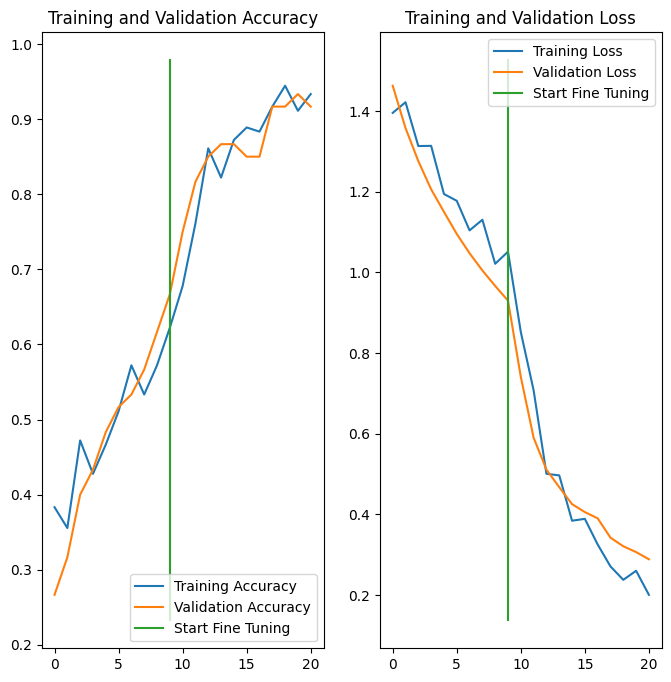

In [ ]:
# loading up pretrained_history and pretrained_history_fine from drive

acc = pretrained_history['acc'] + pretrained_history_fine['acc']
val_acc = pretrained_history['val_acc'] + pretrained_history_fine['val_acc']

loss = pretrained_history['loss'] + pretrained_history_fine['loss']
val_loss = pretrained_history['val_loss'] + pretrained_history_fine['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
           plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
           plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Evaluation and Prediction**

Finally we will verify the performance of the model on new data using test set.

In [ ]:
x_test, y_test  = test_images, test_labels_ids

loss, accuracy = pretrained_model.evaluate(x_test,y_test)
print('Test accuracy :', accuracy)

2/2 [==============================] - 5s 1s/step - loss: 0.3009 - acc: 0.8667
Test accuracy : 0.8666666746139526


Actual: apple
Predicted: apple
This image most likely belongs to a apple with a 99.5319% confidence.


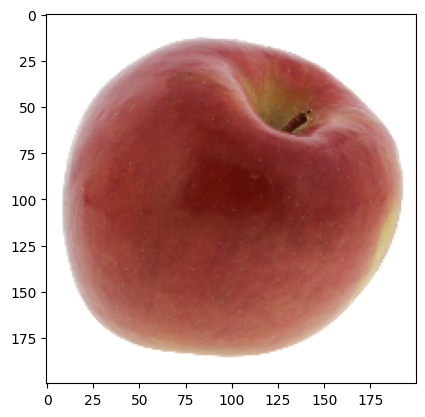

In [ ]:
# Testing predictions and the actual label
random = randint(0, len(test_labels)-1)

checkImage = test_images[random-1:random]
checklabel = test_labels[random]

predict = pretrained_model.predict(np.array(checkImage), verbose = 0)

output = { 0:'apple',1:'banana',2:'mixed',3:'orange'}
img_rgb = cv2.cvtColor(test_images[random], cv2.COLOR_BGR2RGB)

print("Actual:",checklabel)
plt.imshow(img_rgb)
print("Predicted:",output[np.argmax(predict)])

print("This image most likely belongs to a", output[np.argmax(predict)], "with a" , "{:.4f}".format(100*np.max(predict[0]), 3) + "% confidence.")

## **Predicting New Data**

Use our Pre-Trained MobileNet model to classify an image that wasn't included in the training, validation or test sets.

This image most likely belongs to a apple with a 55.9478% confidence.


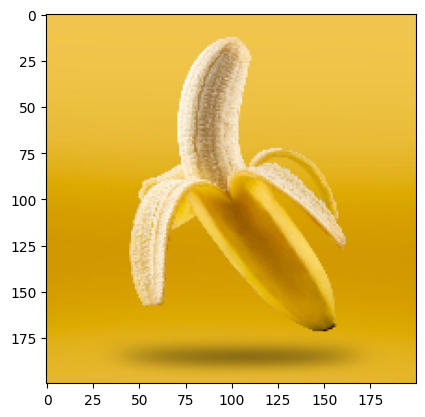

In [ ]:
banana_url = "https://parade.com/.image/ar_1:1%2Cc_fill%2Ccs_srgb%2Cfl_progressive%2Cq_auto:good%2Cw_1200/MTk3MDYyOTU3MDI3MzA0NzY3/are-bananas-good-for-you.jpg"
banana_path = tf.keras.utils.get_file(origin=banana_url)

img = tf.keras.utils.load_img(
    banana_path, target_size=(200, 200)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predict = pretrained_model.predict(np.array(img_array), verbose = 0)

output = { 0:'apple',1:'banana',2:'mixed',3:'orange'}
plt.imshow(img)

print("This image most likely belongs to a", output[np.argmax(predict)], "with a" , "{:.4f}".format(100*np.max(predict[0]), 3) + "% confidence.")

Use our Pre-Trained MobileNet model to classify an image from another dataset.

Actual: orange
Predicted: orange
This image most likely belongs to a orange with a 94.6616% confidence.


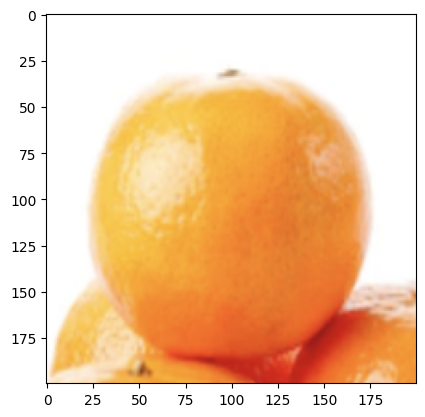

In [ ]:
random_number = randint(0,2) #choose random number to get freshapples, freshbanana or freshoranges

fruit_function = fruit_function_list[random_number]
fruit_label = fruit_label_list[random_number]

random = randint(0, len(fruit_function)-1)

checkImage = fruit_function[random-1:random] #from chosen fruit, choose random number to get specific image of chosen fruit
checklabel = fruit_label[0]

predict = pretrained_model.predict(np.array(checkImage), verbose = 0)

output = { 0:'apple',1:'banana',2:'mixed', 3:'orange'}
img_rgb = cv2.cvtColor(fruit_function[random], cv2.COLOR_BGR2RGB)

print("Actual:",checklabel)
plt.imshow(img_rgb)
print("Predicted:",output[np.argmax(predict)])

print("This image most likely belongs to a", output[np.argmax(predict)], "with a" , "{:.4f}".format(100*np.max(predict[0]), 3) + "% confidence.")